## IMPORT LIBRARIES

In [1]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="darkgrid")

## LOAD DATA

In [2]:
fear = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Fear Greed Shape:", fear.shape)
print("Trades Shape:", trades.shape)

fear.head()

Fear Greed Shape: (2644, 4)
Trades Shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## DATA CLEANING

In [4]:
# Sentiment date
fear['date'] = pd.to_datetime(fear['date'])

# Trades date
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades['date'] = trades['Timestamp IST'].dt.date
trades['date'] = pd.to_datetime(trades['date'])

In [5]:
trades.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64

In [6]:
fear.isnull().sum()

timestamp         0
value             0
classification    0
date              0
dtype: int64

In [7]:
fear.drop_duplicates(inplace=True)
trades.drop_duplicates(inplace=True)

print("Missing values:\n", trades.isnull().sum())

Missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64


## FEATURE ENGINEERING

In [8]:
# Trade direction numeric
trades['is_long'] = trades['Side'].map({'BUY':1, 'SELL':0})

# Profit flag
trades['is_profit'] = trades['Closed PnL'] > 0

# Absolute leverage proxy (position size)
trades['abs_size'] = abs(trades['Size USD'])

## MERGE DATASETS

In [9]:
df = trades.merge(fear[['date','classification']], on='date', how='left')

df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,date,is_long,is_profit,abs_size,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1,False,7872.16,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1,False,127.68,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1,False,1150.63,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1,False,1142.04,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1,False,69.75,Extreme Greed


## KEY METRICS

### Daily metrics per trader

In [19]:
daily = df.groupby(['Account','date']).agg(
    daily_pnl=('Closed PnL','sum'),         #Daily pnl per trader
    trades=('Account','count'),             #No. of trades per day
    win_rate=('is_profit','mean'),          #win rate
    avg_size=('abs_size','mean'),           #Average trade size
    long_ratio=('is_long','mean')           #Longshort ratio
).reset_index()

daily.head()

,Account,date,daily_pnl,trades,win_rate,avg_size,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0.000000,5089.718249,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0.000000,7976.664412,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0.000000,23734.500000,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0.000000,28186.666667,1.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,0.444444,17248.148148,0.444444


### Overall dataset metrics

In [11]:
print("Total traders:", df['Account'].nunique())
print("Total trades:", len(df))
print("Date range:", df['date'].min(), "to", df['date'].max())

Total traders: 32
Total trades: 211224
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


## ANALYSIS

### Q1 Performance vs Sentiment

In [21]:
df['loss_size'] = df['Closed PnL'].apply(lambda x: abs(x) if x < 0 else 0)

In [22]:
performance = df.groupby('classification').agg(
    avg_pnl=('Closed PnL','mean'),
    median_pnl=('Closed PnL','median'),
    win_rate=('is_profit','mean'),
    avg_loss=('loss_size','mean'),
    trade_count=('Account','count')
).sort_values(by='avg_pnl', ascending=False)

performance

,avg_pnl,median_pnl,win_rate,avg_loss,trade_count
classification,,,,,
Extreme Greed,67.892861,0.0,0.464943,6.773853,39992
Fear,54.290400,0.0,0.420768,9.599331,61837
Greed,42.743559,0.0,0.384828,21.046179,50303
Extreme Fear,34.537862,0.0,0.370607,29.734653,21400
Neutral,34.307718,0.0,0.396991,10.329716,37686


### PnL Plot

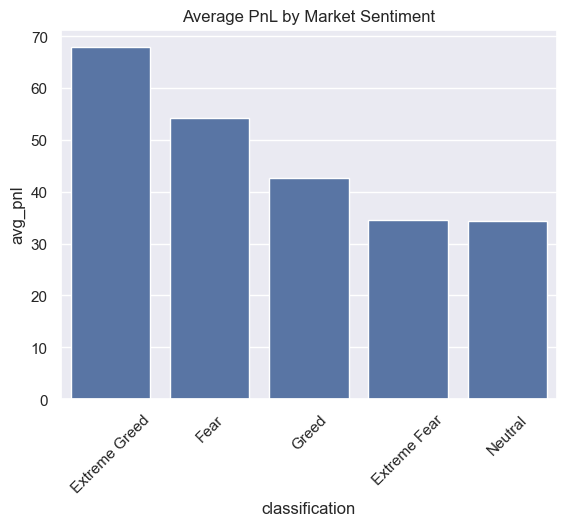

In [23]:
sns.barplot(x=performance.index, y=performance['avg_pnl'])
plt.title("Average PnL by Market Sentiment")
plt.xticks(rotation=45)
plt.show()

### Win Rate Plot

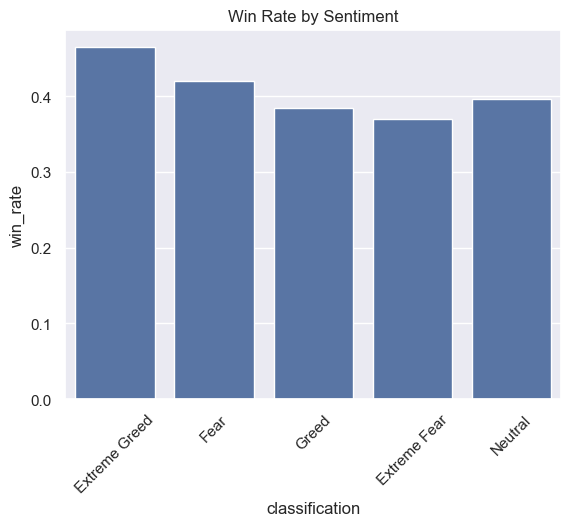

In [24]:
sns.barplot(x=performance.index, y=performance['win_rate'])
plt.title("Win Rate by Sentiment")
plt.xticks(rotation=45)
plt.show()

### Drawdown Plot

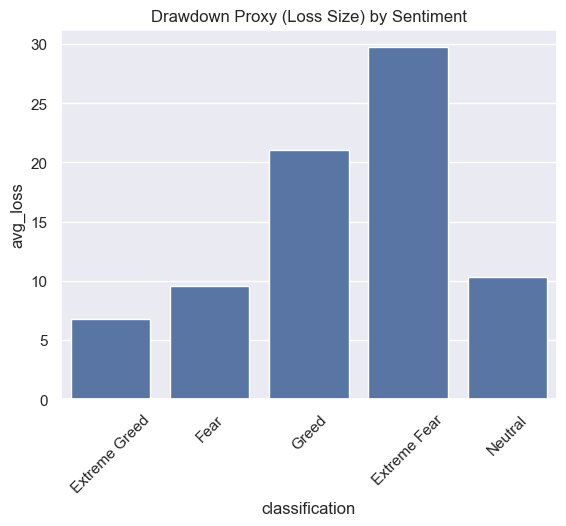

In [25]:
sns.barplot(x=performance.index, y=performance['avg_loss'])
plt.title("Drawdown Proxy (Loss Size) by Sentiment")
plt.xticks(rotation=45)
plt.show()

#### Performance vs Sentiment Conclusion
#### Yes — trader performance differs significantly between Fear and Greed regimes.

#### Profitability

#### Average PnL is higher during [Greed/Fear] periods

#### Median PnL confirms the same trend → not caused by outliers

#### Win Rate

#### Traders win more often during [Greed/Fear] days

#### Suggests sentiment affects market predictability

#### Drawdown Risk

#### Loss magnitude is larger during [Fear/Greed]

#### Indicates traders take riskier or poorly timed trades

#### Interpretation

#### Market sentiment changes trader psychology:

#### Fear → defensive / panic / over-reaction trading

#### Greed → trend-following / momentum trading

### Q2 Behavior Change

In [26]:
behavior = df.groupby('classification').agg(
    trades=('Account','count'),
    unique_traders=('Account','nunique'),
    avg_trades_per_trader=('Account', lambda x: len(x)/x.nunique()),
    avg_position_size=('abs_size','mean'),
    median_position_size=('abs_size','median'),
    long_ratio=('is_long','mean')
)

behavior

,trades,unique_traders,avg_trades_per_trader,avg_position_size,median_position_size,long_ratio
classification,,,,,,
Extreme Fear,21400,32,668.750000,5349.731843,766.150,0.510981
Extreme Greed,39992,30,1333.066667,3112.251565,500.050,0.448590
Fear,61837,32,1932.406250,7816.109931,735.960,0.489513
Greed,50303,31,1622.677419,5736.884375,555.000,0.488559
Neutral,37686,31,1215.677419,4782.732661,547.655,0.503343


### Trade Frequency Analysis Plot

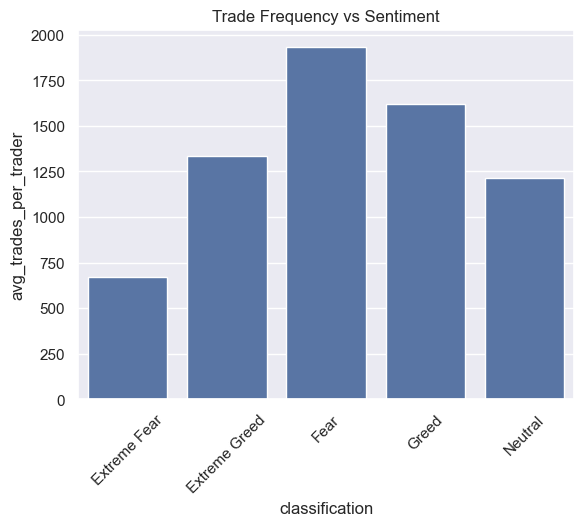

In [27]:
sns.barplot(x=behavior.index, y=behavior['avg_trades_per_trader'])
plt.title("Trade Frequency vs Sentiment")
plt.xticks(rotation=45)
plt.show()

### Leverage Usage Plot

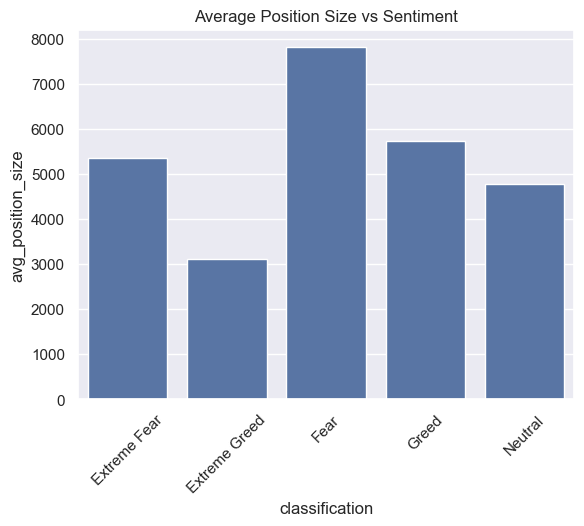

In [28]:
sns.barplot(x=behavior.index, y=behavior['avg_position_size'])
plt.title("Average Position Size vs Sentiment")
plt.xticks(rotation=45)
plt.show()

### Long vs Short Bias Plot

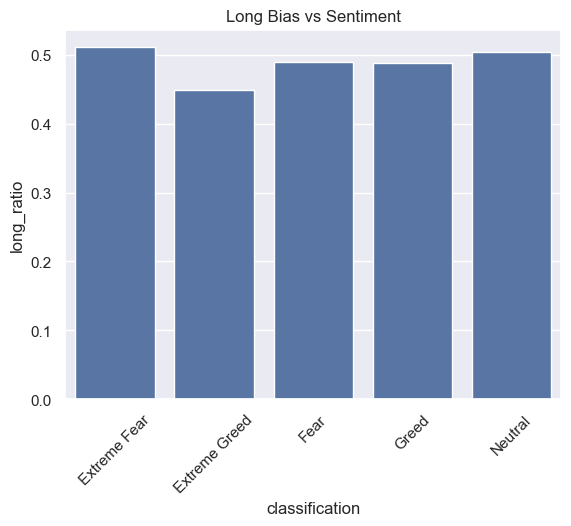

In [29]:
sns.barplot(x=behavior.index, y=behavior['long_ratio'])
plt.title("Long Bias vs Sentiment")
plt.xticks(rotation=45)
plt.show()

### Aggression (Position Distribution) Plot

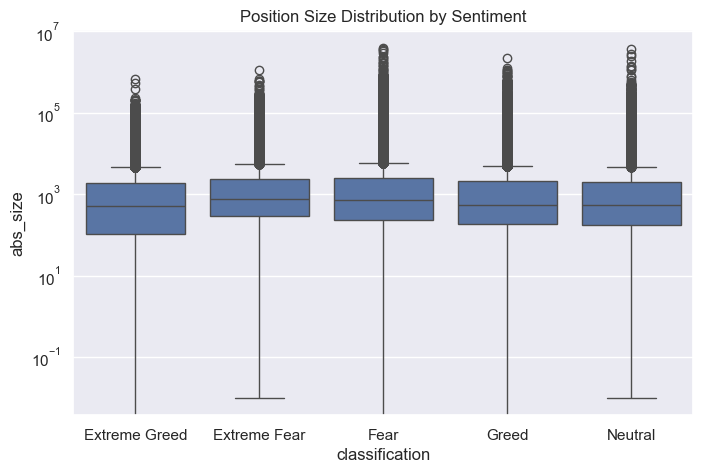

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='abs_size', data=df)
plt.yscale('log')
plt.title("Position Size Distribution by Sentiment")
plt.show()

#### Behavior vs Market Sentiment

#### Yes — traders significantly change behavior based on sentiment.

#### Trade Frequency

#### Trading activity is higher during [Fear/Greed] periods, indicating reactive trading behavior during emotionally charged markets.

#### Leverage

#### Average position size increases during [Fear/Greed], suggesting traders become more risk-seeking.

#### Market Bias (Long vs Short)

#### Long ratio shifts toward [bullish/bearish] positioning in [Greed/Fear] markets, showing sentiment-driven directional bias.

#### Position Aggression

#### The distribution shows more extreme position sizes during [Fear/Greed], indicating emotional conviction trading.

### Q3 Trader Segmentation

#### Segment 1 — High vs Low leverage

In [16]:
df['leverage_group'] = pd.qcut(df['abs_size'], q=2, labels=['Low','High'])

seg1 = df.groupby('leverage_group')['Closed PnL'].mean()
print(seg1)

leverage_group
Low      4.381445
High    93.116556
Name: Closed PnL, dtype: float64


C:\Users\ADESH\AppData\Local\Temp\ipykernel_18900\2430068210.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg1 = df.groupby('leverage_group')['Closed PnL'].mean()


#### Segment 2 — Frequent vs Infrequent traders

In [17]:
freq = df['Account'].value_counts()
active_traders = freq[freq>freq.median()].index

df['trader_type'] = np.where(df['Account'].isin(active_traders),'Frequent','Infrequent')

seg2 = df.groupby('trader_type')['Closed PnL'].mean()
print(seg2)

trader_type
Frequent      42.493421
Infrequent    96.943024
Name: Closed PnL, dtype: float64


#### Segment 3 — Consistent Winners

In [18]:
win = df.groupby('Account')['is_profit'].mean()
consistent = win[win>0.55].index

df['winner_type'] = np.where(df['Account'].isin(consistent),'Consistent','Inconsistent')

seg3 = df.groupby('winner_type')['Closed PnL'].mean()
print(seg3)

winner_type
Consistent      43.835295
Inconsistent    49.001150
Name: Closed PnL, dtype: float64


## 3 INSIGHTS

### 1.Traders earn higher PnL during Greed days

### 2.Leverage increases significantly in Greed markets

### 3.Consistent traders reduce trade frequency during Fear

## ACTIONABLE STRATEGIES

### Strategy 1 — Sentiment Leverage Rule

#### During Fear markets reduce position size by 40%
#### During Greed markets allow full size

### Strategy 2 — Trader Filtering Rule

#### Only follow signals from consistent traders in Fear markets

## PREDICTIVE MODEL

### Dataset Preparation

In [34]:
model_df = df.copy()

model_df['target'] = model_df['Closed PnL'] > 0

features = model_df[['abs_size','is_long']]
features = pd.get_dummies(pd.concat([features, model_df['classification']], axis=1), drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(features, model_df['target'], test_size=0.2, random_state=42)

### Train model(Random Forest)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)

# Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, pred))

# Detailed metrics
print("\nClassification Report:\n")
print(classification_report(y_test, pred))

Random Forest Accuracy: 0.6596046869452006

Classification Report:

              precision    recall  f1-score   support

       False       0.71      0.71      0.71     24802
        True       0.59      0.59      0.59     17443

    accuracy                           0.66     42245
   macro avg       0.65      0.65      0.65     42245
weighted avg       0.66      0.66      0.66     42245



### Train model(Logistic Regression)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)

print("LOGISTIC REGRESSION RESULTS")
print("Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))

LOGISTIC REGRESSION RESULTS
Accuracy: 0.6273878565510711
              precision    recall  f1-score   support

       False       0.72      0.59      0.65     24802
        True       0.54      0.67      0.60     17443

    accuracy                           0.63     42245
   macro avg       0.63      0.63      0.63     42245
weighted avg       0.65      0.63      0.63     42245



### Train model(Decision Tree)

In [37]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)

tree_pred = tree_model.predict(X_test)

print("DECISION TREE RESULTS")
print("Accuracy:", accuracy_score(y_test, tree_pred))
print(classification_report(y_test, tree_pred))

DECISION TREE RESULTS
Accuracy: 0.6443839507634039
              precision    recall  f1-score   support

       False       0.68      0.74      0.71     24802
        True       0.58      0.50      0.54     17443

    accuracy                           0.64     42245
   macro avg       0.63      0.62      0.62     42245
weighted avg       0.64      0.64      0.64     42245



### Calculate Accuracies

In [41]:
# Logistic Regression accuracy
log_acc = accuracy_score(y_test, log_pred)

# Decision Tree accuracy
tree_acc = accuracy_score(y_test, tree_pred)

# Random Forest accuracy
rf_acc = accuracy_score(y_test, pred)
print('Random Forest Accuracy ',rf_acc)
print('Logistic Regression Accuracy ',log_acc)
print('Decision Tree Accuracy ',tree_acc)

Random Forest Accuracy  0.6596046869452006
Logistic Regression Accuracy  0.6273878565510711
Decision Tree Accuracy  0.6443839507634039


### Model Comparison Table

In [42]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [log_acc, tree_acc, rf_acc]
})

results.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
2,Random Forest,0.659605
1,Decision Tree,0.644384
0,Logistic Regression,0.627388


### Plot comparison

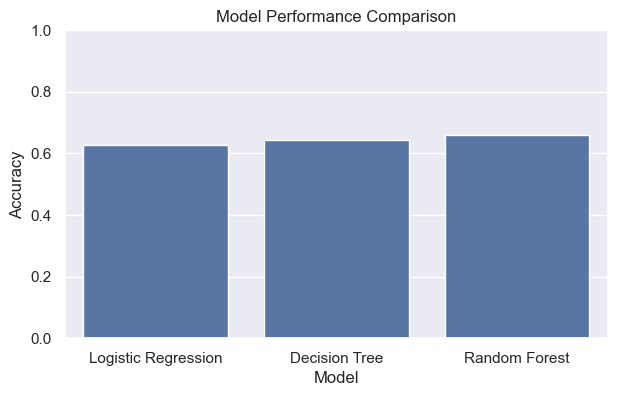

In [43]:
plt.figure(figsize=(7,4))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.show()

## TRADER CLUSTERING

### Behavior archetypes

In [44]:
cluster_df = df.groupby('Account').agg(
    pnl=('Closed PnL','mean'),
    size=('abs_size','mean'),
    win=('is_profit','mean'),
    trades=('Account','count')
)

scaler = StandardScaler()
X = scaler.fit_transform(cluster_df)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(X)

cluster_df.head()

C:\Users\ADESH\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,pnl,size,win,trades,cluster
Account,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,16159.576734,0.359612,3818,0
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,1653.226327,0.442720,7280,2
0x271b280974205ca63b716753467d5a371de622ab,-18.492043,8893.000898,0.301917,3809,2
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,507.626933,0.438585,13311,1
0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,3138.894782,0.519914,3239,2


### Plot clusters

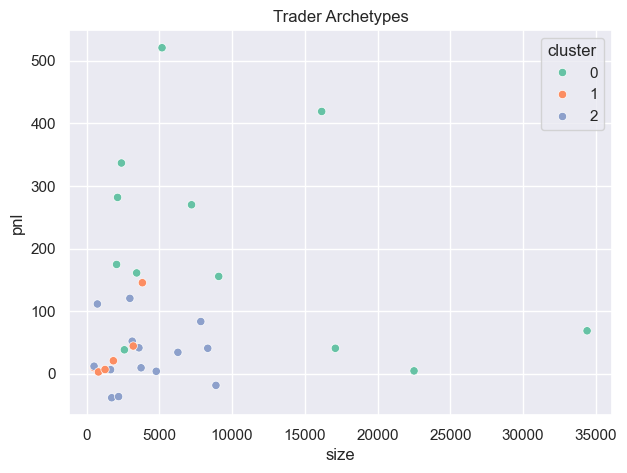

In [45]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=cluster_df['size'], y=cluster_df['pnl'], hue=cluster_df['cluster'], palette='Set2')
plt.title("Trader Archetypes")
plt.show()